# Visual analysis

In [73]:
import fastf1
import fastf1.plotting
from fastf1.livetiming.data import LiveTimingData

import pandas as pd
import numpy as np
import math

from datetime import datetime, timedelta
from timple.timedelta import strftimedelta
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import FormatStrFormatter

In [2]:
df = pd.read_csv("C:/Users\lmbfr\OneDrive\Documents\Travail ESILV\Cours + Exercices\Semestre 7\Python Data Analysis\F1\completeWeekendsData.csv")

In [3]:
df.head(2)

,number,position,Q1,Q2,Q3,positionText,points,grid,laps,status,...,code,DriverNationality,constructorId,constructorNationality,fastestLapNumber,fastestLapRank,fastestLapAvgSpeed,fastestLapTime,totalTime,TimeInterval
0,44,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,HAM,British,mercedes,German,10.0,1.0,NaN,0 days 00:01:33.999000,NaN,NaN
1,7,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,RAI,Finnish,ferrari,Italian,12.0,2.0,NaN,0 days 00:01:34.358000,NaN,NaN


### Team colors mapping for plots

In [242]:
#teamColors = ['alfa romeo': '#900000', 'alphatauri': '#2b4562', 'alpine': '#0090ff', 'aston martin': '#006f62', 'ferrari': '#dc0000', 'force_india': '#F596C8', 'haas': '#ffffff', 'mclaren': '#ff8700', 'mercedes': '#00d2be', 'racing_point': '#F596C8', 'red bull': '#0600ef', 'renault': '#FFF500', 'sauber' : '#9B0000', 'toro_rosso': '#0032FF', 'williams': '#005aff']
teamList = df['constructorId'].unique().tolist()
teamList.sort()
teamColors = ['#900000', '#2b4562', '#0090ff', '#006f62', '#dc0000', '#F596C8', '#ffffff', '#ff8700', '#00d2be', '#F596C8', '#0600ef', '#FFF500', '#9B0000', '#0032FF', '#005aff']
dictTeamColors = dict(zip(teamList, teamColors))
dictTeamColors

{'alfa': '#900000',
 'alphatauri': '#2b4562',
 'alpine': '#0090ff',
 'aston_martin': '#006f62',
 'ferrari': '#dc0000',
 'force_india': '#F596C8',
 'haas': '#ffffff',
 'mclaren': '#ff8700',
 'mercedes': '#00d2be',
 'racing_point': '#F596C8',
 'red_bull': '#0600ef',
 'renault': '#FFF500',
 'sauber': '#9B0000',
 'toro_rosso': '#0032FF',
 'williams': '#005aff'}

### Session retrieval with regex help

In [5]:
#Checks first if number in [1,2,3] exists (--> Practice x), then searches for a "q" (--> Qualification)
#If didn't find any of these conditions (--> Race)
def RetrieveSession(year, gpNumber, sessionName):
    sessionFound = False
    
    digits = re.findall(r'\d', sessionName)
    if (len(digits) > 0):
        if (digits[0] in ['1', '2', '3']):
            sessionName = "Practice " + digits[0]
            sessionFound = True
        
    if (sessionFound == False):
        if (bool(re.search(r'q', sessionName, flags=re.IGNORECASE))):
            sessionName = "Qualifying"
        else:
            sessionName = "Race"
    
    sessionSelected = df[(df["year"] == year) & (df["gpNumber"] == gpNumber) & (df["sessionName"] == sessionName)]
    return sessionSelected

### Formatting methods

In [153]:
def StringToTimeDelta(time):
    try:
        if (time[0] == "+"):
            time = time[1:]
        digits = re.findall(r"\d+", time)
        if (len(digits) == 2):
            delta = timedelta(seconds = int(digits[0]), microseconds = int(digits[1]) * 1000)
        else:
            delta = timedelta(minutes = int(digits[0]), seconds = int(digits[1]), microseconds = int(digits[2]) * 1000)
        return delta
    except:
        return time

In [7]:
def FakeTimeDeltaToTimeDelta(time):
    try:
        min = time[10:12]
        sec = time[13:15]
        thousandth = time[16:19]
        delta = timedelta(minutes = int(min), seconds = int(sec), microseconds = int(thousandth) * 1000)
        return delta
    except:
        return time

In [303]:
def FirstListElement(l):
    if len(l) > 0:
        return int(l[0])
    else:
        return np.NaN

In [319]:
def RaceTimeInterval(x):
    seconds = int(re.findall(r'\d+', str(x))[0])
    if (seconds >= 60):
        seconds = f"{seconds//60}m{seconds%60}"
    return seconds

### Session Ranking Display (Practice, Quali, Race)

In [356]:
def RankingDisplay(session, Number = None):
    
    fig, ax = plt.subplots()
    title = ""
    
    team_colors = list()
    for index, row in session.iterrows():
        color = dictTeamColors[row["constructorId"]]
        team_colors.append(color)
        
    if (bool(re.search(r'practice', session["sessionName"].iloc[0], flags=re.IGNORECASE))):
        session['fastestLapTime'] = session['fastestLapTime'].apply(FakeTimeDeltaToTimeDelta)
        session['DeltaP'] = session['fastestLapTime'] - session['fastestLapTime'].min()
        
        ax.barh(session.index, session['DeltaP'],
                color = team_colors, edgecolor='grey')
        
        ax.set_xticklabels([f"+{x}s" for x in ax.get_xticks()[:-1] / 1000000000])

        ax.set_yticks(session.index)
        ax.set_yticklabels(session['code'])

        ax.invert_yaxis()

        ax.set_axisbelow(True)
        ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

        fastest = session[session["DeltaP"] == timedelta(0)]
        title = session["gpName"].iloc[0] + " " + str(session["year"].iloc[0]) + " " + str(session["sessionName"].iloc[0])
        title += "\nFastest Lap: " + strftimedelta(fastest["fastestLapTime"].iloc[0], '%m:%s.%ms') + " by " + fastest["driverId"].iloc[0].capitalize()
        
        
    
    elif (session["sessionName"].iloc[0] == "Qualifying"):
        session['Q1'] = session['Q1'].apply(StringToTimeDelta)
        session['Q2'] = session['Q2'].apply(StringToTimeDelta)
        session['Q3'] = session['Q3'].apply(StringToTimeDelta)

        session['DeltaQ1'] = session['Q1'] - session['Q1'].min()
        session['DeltaQ2'] = session['Q2'] - session['Q2'].min()
        session['DeltaQ3'] = session['Q3'] - session['Q3'].min()
        
        session = session[session[f'Q{Number}'].notnull()]
    
        ax.barh(session.index, session[f'DeltaQ{Number}'],
                color = team_colors, edgecolor='grey')
        
        #maxDelta = math.ceil(session[f"DeltaQ{Number}"].max().seconds + (session[f"DeltaQ{Number}"].max().microseconds / 1000000))
        #ticksNumber = len(ax.get_xticklabels()) - 1
        #ax.set_xticklabels([f"+{x}s" for x in np.arange(0,maxDelta,round(maxDelta/ticksNumber, 2))])
        
        ax.set_xticklabels([f"+{x}s" for x in ax.get_xticks()[:-1] / 1000000000])

        ax.set_ylabel('Sunday Grid Order', fontsize = 10)
        ax.yaxis.set_label_coords(-0.042, .5)
        ax.set_yticks(session.index)
        ax.set_yticklabels(session['code'])

        ax.invert_yaxis()

        ax.set_axisbelow(True)
        ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

        fastest = session[session[f"DeltaQ{Number}"] == timedelta(0)]
        title = session["gpName"].iloc[0] + " " + str(session["year"].iloc[0]) + f" Qualifying {Number}"
        title += "\nFastest Lap: " + strftimedelta(fastest[f"Q{Number}"].iloc[0], '%m:%s.%ms') + " by " + fastest["driverId"].iloc[0].capitalize()
        
        if (Number in [1,2]):
            for tick in plt.gca().get_yticklabels()[-5:]:
                tick.set_color('red')
    
    else:
        finishTime = session["TimeInterval"].iloc[0]
        session["TimeInterval"].iloc[0] = '+0.0'
        session["TimeInterval"] = session["TimeInterval"].apply(StringToTimeDelta)

        session["LapsBack"] = session["status"].str.findall(r'\d').apply(FirstListElement)

        session["TimeBack"] = session["LapsBack"]*session["fastestLapTime"].apply(StringToTimeDelta).max()
        session["TimeInterval"] = session["TimeBack"].fillna(session["TimeInterval"])
        
        session.replace({pd.NaT: np.NaN}, inplace = True)
        
        sessionR = session[session["TimeInterval"].notnull()]
        sessionR["TimeInterval"] = pd.to_timedelta(sessionR["TimeInterval"])
        
        hbars = ax.barh(sessionR.index, sessionR["TimeInterval"],
                color = team_colors, edgecolor='grey')
        
        ax.set_xticklabels([f"+{RaceTimeInterval(x)}s" for x in ax.get_xticks()[:-1] / 1000000000])
        
        ax.set_yticks(sessionR.index)
        ax.set_yticklabels(sessionR['code'])

        ax.invert_yaxis()

        ax.set_axisbelow(True)
        ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)
        
        title = sessionR["gpName"].iloc[0] + " " + str(sessionR["year"].iloc[0]) + " " + str(sessionR["sessionName"].iloc[0])
        title += "\nFastest : " + finishTime + " - " + sessionR["driverId"].iloc[0].capitalize()
        
    plt.rcParams["figure.figsize"] = (20,10)
    #plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 12)

    plt.suptitle(title, y = 0.95, fontsize=16)
    
    plt.show()
    
    #Extra race information
    if (session["sessionName"].iloc[0] == "Race"):
        print(session[session["TimeInterval"].isna()][['code', 'status']].to_string(index=False))
    

## Plotting Examples

<ipython-input-356-789b570a636f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session['fastestLapTime'] = session['fastestLapTime'].apply(FakeTimeDeltaToTimeDelta)
<ipython-input-356-789b570a636f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session['DeltaP'] = session['fastestLapTime'] - session['fastestLapTime'].min()
<ipython-input-356-789b570a636f>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"+{x}s" for x in ax.get_xticks()[:-1] / 10000

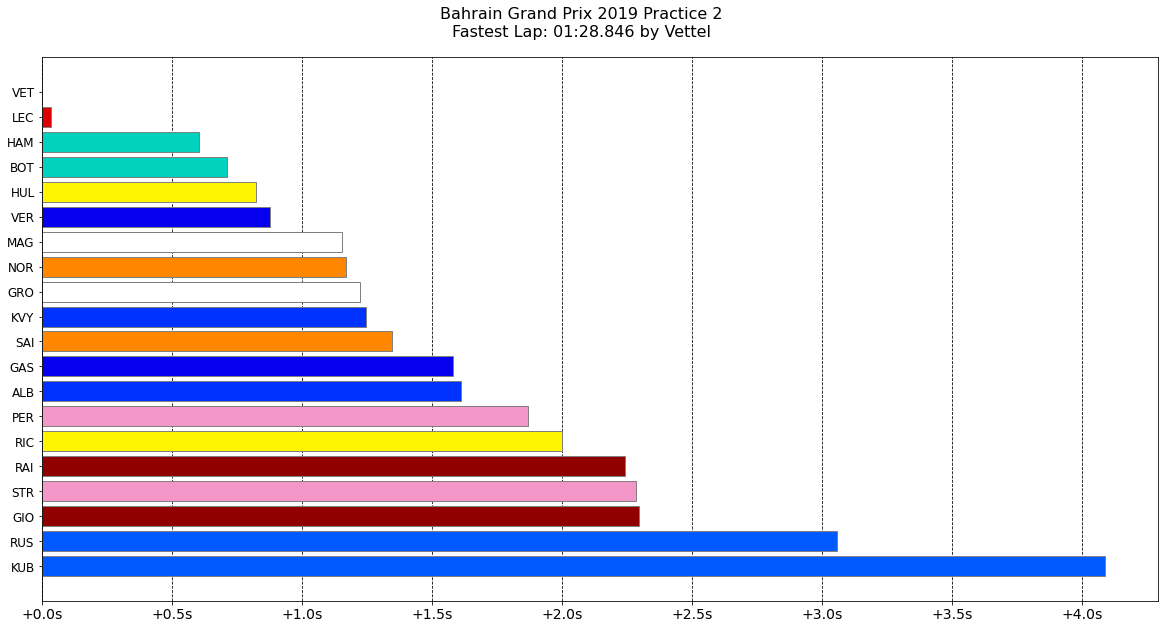

In [363]:
session = RetrieveSession(2019, 2, 'P2')
RankingDisplay(session)

<ipython-input-356-789b570a636f>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session['Q1'] = session['Q1'].apply(StringToTimeDelta)
<ipython-input-356-789b570a636f>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session['Q2'] = session['Q2'].apply(StringToTimeDelta)
<ipython-input-356-789b570a636f>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

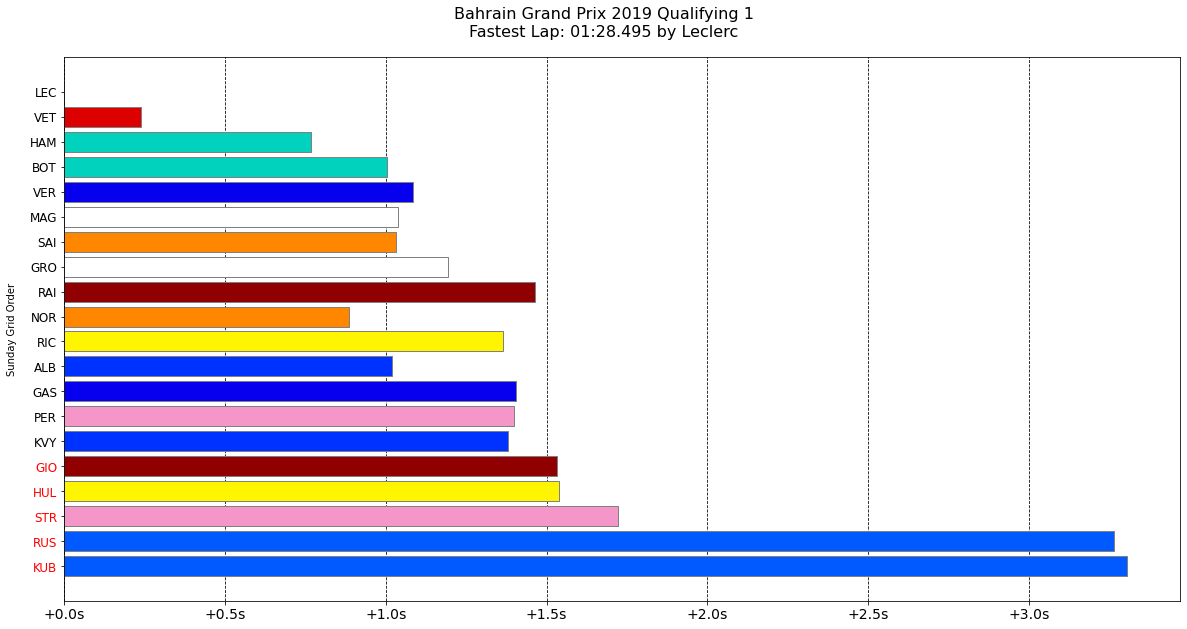

In [364]:
session = RetrieveSession(2019, 2, 'Q')
RankingDisplay(session, 1)

C:\Users\lmbfr\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\lmbfr\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
<ipython-input-356-789b570a636f>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

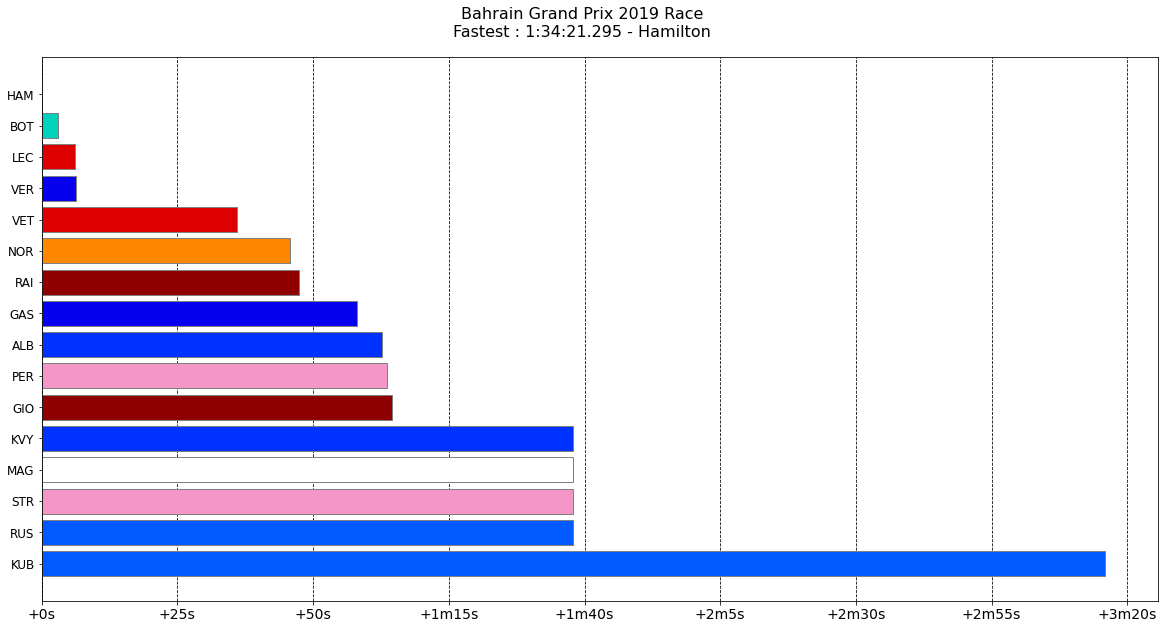

code           status
 HUL           Engine
 RIC      Out of fuel
 SAI Collision damage
 GRO          Retired


In [365]:
session = RetrieveSession(2019, 2, 'R')
RankingDisplay(session)